In [1]:
import os 

# move to project root
while True:
    if os.getcwd().split("/")[-1] == "qa_ai":
        break
    else:
        os.chdir("..")

print(os.getcwd())

/home/ra/Codes/qa_ai


In [2]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from src.compute_and_plot_abroca import compute_abroca

In [3]:
# darkgrid, whitegrid, dark, white, ticks
sns.set(style="ticks", context="paper")
plt.style.use("dark_background")

# Some Utils

In [4]:
def compute_accuracy(confusion_matrix):
    """
    Function to compute accuracy from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns accuracy
    """
    return (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)

In [5]:
def compute_true_positive_rate(confusion_matrix):
    """
    Function to compute true positive rate from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns true positive rate
    """
    return confusion_matrix[1, 1] / np.sum(confusion_matrix[1, :])

In [6]:
def compute_true_negative_rate(confusion_matrix):
    """
    Function to compute true negative rate from confusion matrix
    confusion_matrix - confusion matrix from sklearn.metrics.confusion_matrix
    Returns true negative rate
    """
    return confusion_matrix[0, 0] / np.sum(confusion_matrix[0, :])

In [7]:
def compute_statistical_parity(confusion_matrix_group_1, confusion_matrix_group_2):
    """
    Function to compute statistical parity from confusion matrices of two groups
    confusion_matrix_group_1 - confusion matrix from sklearn.metrics.confusion_matrix for group 1
    confusion_matrix_group_2 - confusion matrix from sklearn.metrics.confusion_matrix for group 2
    Returns statistical parity
    """
    return compute_true_positive_rate(confusion_matrix_group_1) - compute_true_positive_rate(confusion_matrix_group_2)

In [8]:
def compute_equalized_odds(confusion_matrix_group_1, confusion_matrix_group_2):
    """
    Function to compute equalized odds from confusion matrices of two groups
    confusion_matrix_group_1 - confusion matrix from sklearn.metrics.confusion_matrix for group 1
    confusion_matrix_group_2 - confusion matrix from sklearn.metrics.confusion_matrix for group 2
    Returns equalized odds
    """
    return abs(
        compute_true_positive_rate(confusion_matrix_group_1) - compute_true_positive_rate(confusion_matrix_group_2)
    ) + abs(
        compute_true_negative_rate(confusion_matrix_group_1) - compute_true_negative_rate(confusion_matrix_group_2)
    )

# Structure
1. Load data
2. Data Visualization
3. Preprocessing
4. Model
5. Evaluation
6. Conclusion

# Loading dataset

In [9]:
data_path = 'data/Homework3_dataset_credit.csv'
data_df = pd.read_csv(data_path)

data_df.head()

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,other-debtors,residence-since,...,other-installment,housing,existing-credits,job,number-maintenance,telephone,foreign-worker,sex,marital-status,class-label
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,none,4,...,none,own,2,skilled employee / official,1,yes,yes,male,divorced/separated,1
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,none,2,...,none,own,1,skilled employee / official,1,none,yes,female,divorced/separated,0
2,no account,12,critical account,education,2096,<100 DM,4<= <7 years,2,none,3,...,none,own,1,unskilled - resident,2,none,yes,male,divorced/separated,1
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,guarantor,4,...,none,for free,1,skilled employee / official,2,none,yes,male,divorced/separated,1
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,none,4,...,none,for free,2,skilled employee / official,2,none,yes,male,divorced/separated,0


In [10]:
# adding age older than 25 column
data_df["older"] = data_df["age"] > 25

In [11]:
# dictionry of types of data
numerical_features = {
    'duration',
    'credit-amount',
    'installment-rate',
    'residence-since',
    'age',
    'existing-credits',
    'number-maintenance',
     }

binary_features = {
    'telephone',
    'foreign-worker',
    'older',
    }

categorical_features = {
    'checking-account',
    'credit-history',
    'purpose',
    'savings-account',
    'employment-since',
    'other-debtors',
    'property',
    'other-installment',
    'housing',
    'job',
    'sex',
    'marital-status',
    }

# Data Visualization

In [12]:
#

In [13]:
# compate number of olders and youngers
older_df = data_df[data_df['older'] == True]
n_older = older_df.shape[0]
print(f'total older data: {n_older}')

younger_df = data_df[data_df['older'] == False]
n_younger = younger_df.shape[0]
print(f'total younger data: {n_younger}')


total older data: 810
total younger data: 190


In [14]:
n_passed_old = older_df[older_df['class-label'] == 1.0].shape[0]
n_passed_young = younger_df[younger_df['class-label'] == 1.0].shape[0]

print(f'older pass bar: {n_passed_old}')
print(f'younger pass bar: {n_passed_young}')

older pass bar: 590
younger pass bar: 110


In [15]:
print(f'older pass rate: {n_passed_old / n_older}')
print(f'younger pass rate: {n_passed_young / n_younger}')

older pass rate: 0.7283950617283951
younger pass rate: 0.5789473684210527


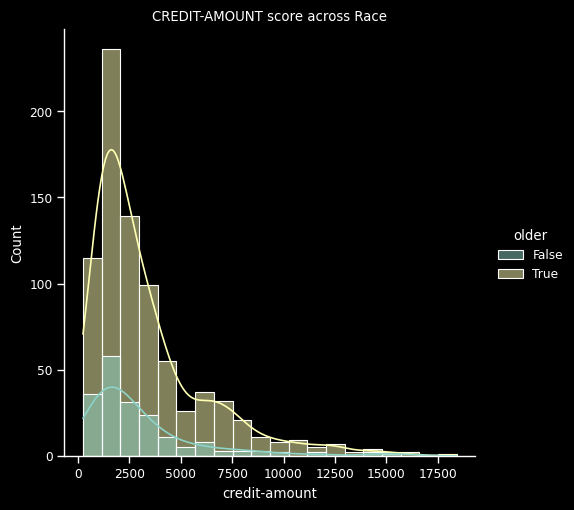

In [16]:
# plot distribution of lsat scores across races
var = 'credit-amount'
sns.displot(data=data_df, x=var, hue='older', kde=True, bins=20)
plt.title(f'{var.upper()} score across Race')
plt.show()

# Pre-processing

In [42]:
## Training Test Split
train_df = data_df.sample(frac=0.8, random_state=42)
test_df = data_df.drop(train_df.index)

In [43]:
older_idx = test_df['older'] == True
younger_idx = test_df['older'] == False

In [44]:
# standardize numerical features
for feature in numerical_features:
    scaler = StandardScaler()
    train_df[feature] = scaler.fit_transform(train_df[feature].values.reshape(-1,1))
    test_df[feature] = scaler.transform(test_df[feature].values.reshape(-1,1))

In [45]:
# one-hot encode categorical features
for feature in categorical_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [46]:
train_df.head()

,duration,credit-amount,installment-rate,residence-since,age,existing-credits,number-maintenance,telephone,foreign-worker,class-label,...,sex_female,sex_male,housing_for free,housing_own,housing_rent,credit-history_all credits at this bank paid back duly,credit-history_critical account,credit-history_delay in paying off,credit-history_existing credits paid back duly till now,credit-history_no credits taken
521,-0.248354,-0.033686,-0.854740,-0.771088,-1.016476,-0.695132,-0.438464,none,yes,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
737,-0.248354,0.392868,0.034456,1.029993,-0.057125,-0.695132,2.280691,yes,yes,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
740,0.239013,-0.343744,-0.854740,0.129453,-0.318766,-0.695132,-0.438464,none,yes,1,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
660,-0.735722,-0.712229,0.034456,1.029993,-1.103690,-0.695132,-0.438464,none,yes,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
411,0.970064,1.422691,0.034456,-0.771088,-0.057125,1.053628,-0.438464,yes,yes,1,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
# one hot encode binary features
for feature in binary_features:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[feature], prefix=feature, dtype=float, drop_first=True)], axis=1)

    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

In [48]:
test_older_df = test_df[older_idx]
test_younger_df = test_df[younger_idx]

# Models

## Logistic Regression

In [49]:
target_label = 'class-label'

In [50]:
# create logistic regression instance
lreg = LogisticRegression(penalty='l2')

# fit model
lreg.fit(train_df.drop(target_label, axis=1), train_df[target_label])

# get predictions on test set
lreg_y_pred = lreg.predict(test_df.drop(target_label, axis=1))
lreg_y_proba = lreg.predict_proba(test_df.drop(target_label, axis=1))

lreg_w_y_pred = lreg.predict(test_older_df.drop(target_label, axis=1))
lreg_nw_y_pred = lreg.predict(test_younger_df.drop(target_label, axis=1))

# get confusion matrix
lreg_confusion_matrix = confusion_matrix(test_df[target_label], lreg_y_pred)
lreg_w_confusion_matrix = confusion_matrix(test_older_df[target_label], lreg_w_y_pred)
lreg_nw_confusion_matrix = confusion_matrix(test_younger_df[target_label], lreg_nw_y_pred)

## Random Forest

In [51]:
rforest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# fit model
rforest.fit(train_df.drop(target_label, axis=1), train_df[target_label])

# get predictions on test set
rforest_y_pred = rforest.predict(test_df.drop(target_label, axis=1))
rforest_y_proba = rforest.predict_proba(test_df.drop(target_label, axis=1))

rforest_w_y_pred = rforest.predict(test_older_df.drop(target_label, axis=1))
rforest_nw_y_pred = rforest.predict(test_younger_df.drop(target_label, axis=1))

# get confusion matrix
rforest_confusion_matrix = confusion_matrix(test_df[target_label], rforest_y_pred)
rforest_w_confusion_matrix = confusion_matrix(test_older_df[target_label], rforest_w_y_pred)
rforest_nw_confusion_matrix = confusion_matrix(test_younger_df[target_label], rforest_nw_y_pred)

# Metrics

In [55]:
def compute_metrics(c_matrices):
    accuracies = {}

    for model in c_matrices.keys():
        accuracies[model] = {}
        for group in c_matrices[model].keys():
            accuracies[model][group] = compute_accuracy(c_matrices[model][group])
            print(f'{model} {group} accuracy: {accuracies[model][group]}')
    print('\n')

    # tpr 
    tprs = {}

    for model in c_matrices.keys():
        tprs[model] = {}
        for group in c_matrices[model].keys():
            tprs[model][group] = compute_true_positive_rate(c_matrices[model][group])
            print(f'{model} {group} TPR: {tprs[model][group]}')
    print('\n')
    
    # tnr
    tnrs = {}

    for model in c_matrices.keys():
        tnrs[model] = {}
        for group in c_matrices[model].keys():
            tnrs[model][group] = compute_true_negative_rate(c_matrices[model][group])
            print(f'{model} {group} TNR: {tnrs[model][group]}')
    print('\n')

    # statistical parity
    statistical_parity = {}

    for model in c_matrices.keys():
        statistical_parity[model] = compute_statistical_parity(c_matrices[model]['Older'], c_matrices[model]['Younger'])
        print(f'{model} statistical parity: {statistical_parity[model]}')
    print('\n')

    # equalized odds
    equalized_odds = {}

    for model in c_matrices.keys():
        equalized_odds[model] = compute_equalized_odds(c_matrices[model]['Older'], c_matrices[model]['Younger'])
        print(f'{model} equalized odds: {equalized_odds[model]}')
    print('\n')

In [56]:
c_matrices = {
    'Logistic Regression': {
        'All': lreg_confusion_matrix,
        'Older': lreg_w_confusion_matrix,
        'Younger': lreg_nw_confusion_matrix,
    },
    'Random Forest': {
        'All': rforest_confusion_matrix,
        'Older': rforest_w_confusion_matrix,
        'Younger': rforest_nw_confusion_matrix,
    }
}


In [57]:
compute_metrics(c_matrices)

Logistic Regression All accuracy: 0.745
Logistic Regression Older accuracy: 0.7531645569620253
Logistic Regression Younger accuracy: 0.7142857142857143
Random Forest All accuracy: 0.805
Random Forest Older accuracy: 0.8227848101265823
Random Forest Younger accuracy: 0.7380952380952381


Logistic Regression All TPR: 0.8571428571428571
Logistic Regression Older TPR: 0.85
Logistic Regression Younger TPR: 0.9
Random Forest All TPR: 0.9642857142857143
Random Forest Older TPR: 0.9583333333333334
Random Forest Younger TPR: 1.0


Logistic Regression All TNR: 0.48333333333333334
Logistic Regression Older TNR: 0.4473684210526316
Logistic Regression Younger TNR: 0.5454545454545454
Random Forest All TNR: 0.43333333333333335
Random Forest Older TNR: 0.39473684210526316
Random Forest Younger TNR: 0.5


Logistic Regression statistical parity: -0.050000000000000044
Random Forest statistical parity: -0.04166666666666663


Logistic Regression equalized odds: 0.14808612440191388
Random Forest equalized o

In [58]:
test_df.columns

Index(['duration', 'credit-amount', 'installment-rate', 'residence-since',
       'age', 'existing-credits', 'number-maintenance', 'class-label',
       'job_management/ highly qualified employee',
       'job_skilled employee / official',
       'job_unemployed/ unskilled  - non-resident', 'job_unskilled - resident',
       'checking-account_0 <= <200 DM', 'checking-account_<0 DM',
       'checking-account_>= 200 DM ', 'checking-account_no account',
       'other-installment_bank', 'other-installment_none',
       'other-installment_store', 'marital-status_divorced/separated',
       'marital-status_married/widowed', 'other-debtors_co-applicant',
       'other-debtors_guarantor', 'other-debtors_none',
       'employment-since_1<= < 4 years', 'employment-since_4<= <7 years',
       'employment-since_<1 years', 'employment-since_>=7 years',
       'employment-since_unemployed', 'savings-account_100 <= <500 DM',
       'savings-account_500 <= < 1000 DM', 'savings-account_<100 DM',
      

In [59]:
# computing abroca 
## adding prediction column to test dataframes
# copy test_df
test_df_abroca = test_df.copy()

test_df_abroca['lreg_proba'] = lreg_y_proba[:,1]
test_df_abroca['rforest_proba'] = rforest_y_proba[:,1]

# map pass_bar to 1 and 0
test_df_abroca[target_label] = test_df_abroca[target_label].map({1.0: 1, 0.0: 0})

## map race_White to white and non-white
test_df_abroca['older_True'] = test_df_abroca['older_True'].map({1.0: 'Older', 0.0: 'Younger'})

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


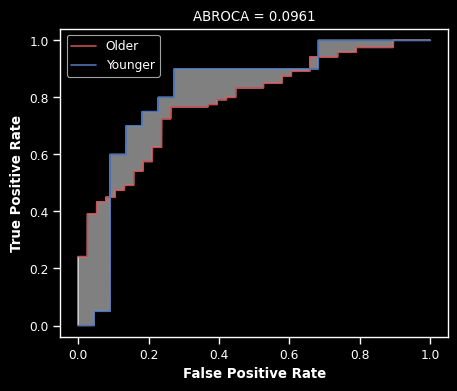

In [61]:
compute_abroca(
    test_df_abroca, 
    pred_col='lreg_proba', 
    label_col=target_label, 
    p_attr_col='older_True', 
    np_p_attr_val='Older', 
    plot_slices=True,
    np_group_name = 'Older',
    p_group_name = 'Younger')

/home/ra/Codes/qa_ai/src/compute_and_plot_abroca.py:170: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slice, _ = integrate.quad(f2, lb, ub, limit)


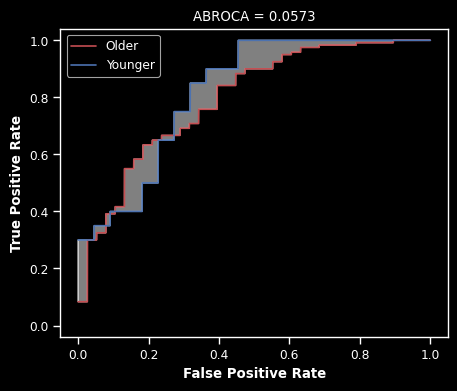

In [63]:
compute_abroca(
    test_df_abroca, 
    pred_col='rforest_proba', 
    label_col=target_label, 
    p_attr_col='older_True', 
    np_p_attr_val='Older', 
    plot_slices=True,
    np_group_name = 'Older',
    p_group_name = 'Younger')